## LandTrendr Implementation For Decadal Averaging of Spectral Indices

# Requirements: 

Python:

* geemap
* ee
* matplotlib
* numpy
* pandas
* oeel ** 

Other:
* Google Earth Engine Account

The LandTrendr algorithm is highly efficient and extensive tool with documentation at this link: https://emapr.github.io/LT-GEE/

This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2

** this package allows the user to run GEE modules directly without the pitfalls of translating JS to Python.

In [1]:
%config IPCompleter.use_jedi = False

import ee
import geemap
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
import os
# Import date class from datetime module
from datetime import datetime as dt
import datetime
import pytz

### save the date as a variable to use for version control

In [2]:
today = dt.today()
print("Today is: ", today)

Today is:  2023-02-18 00:59:19.015958


 # GEE Authentication
 
 - The ee.authenticate line is necessary the first time using ee (and roughly every week thereafter)
 - Authentication requires the user to log into their Earth Engine account which will provide the opportunity to copy and paste an a personal authentication code to this notebook granting access to the server. 
 - Authentication lasts for roughly one week, whereupon the "token required" error on the subsequent "ee.initialize" cell will signal the need to re-do the authentication step.
 - Simply comment and un-comment the ee.authenticate cell below when required
 
 
 ### Paste the Authetication code into the box below. 
 
 (press enter to save token, comment out this box until prompted again )


In [3]:
#ee.Authenticate()

In [4]:
geemap.ee_initialize()

### New version control of inputs and outputs

* best to check that catchment hydroclimatic information is indeed the most reliable/latest available
* 


In [5]:
p = '..'

l_BE = pd.read_csv(f"{p}\Inputs\Version_2_20230214\BE.csv").catchment.tolist()
l_FR = pd.read_csv(f"{p}\Inputs\Version_2_20230214\FR.csv").catchment.tolist()

ls = l_BE+l_FR

def drop_space(i) -> str:
    '''
    Since the FR and BE data is given with indices using catchment names,
    it is necessary to check and drop the space at the end of each name where applicable.
    
    list the letters, check the last charachter and delete if necessary. 
    '''
    
    ls = list(i)
    
    if ls[-1] == ' ':
        i = i[:-1]
    else:
        i = i
    return i


names = [drop_space(i) for i in ls]

print(f'{len(names)} catchments processed for hydroclimatic variables:\n \n{names}')

23 catchments processed for hydroclimatic variables:
 
['Membre Pont', 'Straimont', 'Treignes', 'Chooz', 'Daverdisse', 'Jemelle', 'Hastiere', 'Warnant', 'Ortho', 'Wiheries', 'Salzinnes', 'Huccorgne', 'Amay', 'La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']


### Load the EE package

The landTrendr package is developed to construct timeseries of landsat imagery for the purpose of land cover detection. The base parameters are optimised for deforestation event detection. 

This utilisation of the GEE asset (with apache license i.e. free for use) allows for the latest version of LandTrendr to be used. In contrast to early versions this allows for the utilisation of the Landsat Collection 2 reprocessing effort with improvements in cloud masking capabilities. Primarily we use "ltgee.buildSRcollection"

In [6]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v4.js')

#ltgee.availability  #all functions within the javascript module


IMPORTANT! Please be advised:
- This version of the Adapted_LT.js modules
  uses some code adapted from the author: @author Justin Braaten (Google) * @author Zhiqiang Yang (USDA Forest Service) * @author Robert Kennedy (Oregon State University)
The latest edits to this code occur: 10/02/2023 for the adaptation efforts by @Mike OHanrahan (TU DELFT MSc research)
TODO: addition of AVHRR/VIIRS LAI and NDVI2


## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository


In [7]:
asset_dir = 'CATAPUCII_Catchments/Meuse_Catchments_4326_WFLOW'

dataset = 'Meuse'

crs = 'EPSG:4326'

fignum = 0

RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

In [8]:
startYear = 1984

endYear = 2022

startDay = '06-20'

endDay = '08-31'

maskThese = ['cloud', 'shadow', 'snow',]

bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 


## The Table Data

- Here the table, a vector of catchments, is loaded from the users' assets in earth engine 

#TODO rewrite to a local .shp

- The area is calculated of each shape and ranked per area, assuming that the largest is the most computationally expensive
- This is done so that we can iterate from smallest to largest, or the opposite, should any memory issues become apparent.

In [9]:
table = ee.FeatureCollection(f"projects/mohanrahan/assets/{asset_dir}")

def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

def set_area_pixel(feature):
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':'EPSG:4326',
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)


Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)  # true ranks from smallest to largest

down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])

df1 = down.loc[down['Stations_M'].isin(names)]

sys_index = df1.index.to_list()

display(df1)

df1.loc[sys_index[-1]]


,pixel_area,area_km2,Stations_3,Stations_2,Stations_1,long_cntrd,lat_cntrd,Stations_M
system_index,,,,,,,,
00000000000000000018,1589.533689,1584.214049,50.092133,4.806526,Chooz,4.867246,49.774258,Chooz
0000000000000000001d,1372.050234,1367.694860,49.493890,5.177972,La Meuse Stenay,5.344417,49.164286,La Meuse Stenay
0000000000000000001e,1347.055442,1342.927162,48.870879,5.530998,La Meuse Saint-Mihiel,5.666623,48.556343,La Meuse Saint-Mihiel
0000000000000000000d,1306.148656,1301.658056,50.536477,5.317771,Amay,4.984290,50.334882,Amay
0000000000000000001b,973.084708,969.907519,49.629141,5.159217,La Chiers Carignan,5.505163,49.491089,La Chiers Carignan
00000000000000000012,907.666741,904.622343,49.863767,4.902010,Membre Pont,5.297871,49.792315,Membre Pont
0000000000000000000e,548.303165,546.432054,50.088626,4.675975,Treignes,4.467033,50.045699,Treignes
0000000000000000001f,442.962882,441.640949,48.402870,5.732146,Le Vair Soulosse-sous-Saint-Élophe,5.882714,48.287026,Le Vair Soulosse-sous-Saint-Élophe
00000000000000000019,405.813979,404.503520,49.660450,4.882686,La Bar Cheveuges,4.834297,49.541173,La Bar Cheveuges


pixel_area                   123.21842
area_km2                    122.802489
Stations_3                    49.72767
Stations_2                    4.714185
Stations_1    La Vence la Francheville
long_cntrd                    4.615253
lat_cntrd                     49.67204
Stations_M    La Vence la Francheville
Name: 00000000000000000015, dtype: object

In [10]:
Filtered_Sorted.first().geometry()

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Element.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.limit",
                "arguments": {
                  "ascending": {
                    "constantValue": false
                  },
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.filter",
                      "arguments": {
                        "collection": {
                          "functionInvocationValue": {
                            "functionName": "Collection.map",
                            "arguments": {
                              "baseAlgorithm": {
                                "functionDefinitionValue": {
                                  "argumentNames": [
                                    "_MAPPING_VAR_0_0"
                                  ],
                                  "body": {
                                    "functionInvocationValue": {
                                      "functionName": "Element.set",
                                      "arguments": {
                                        "key": {
                                          "constantValue": "pixel_area"
                                        },
                                        "object": {
                                          "argumentReference": "_MAPPING_VAR_0_0"
                                        },
                                        "value": {
                                          "functionInvocationValue": {
                                            "functionName": "Dictionary.get",
                                            "arguments": {
                                              "dictionary": {
                                                "functionInvocationValue": {
                                                  "functionName": "Image.reduceRegion",
                                                  "arguments": {
                                                    "bestEffort": {
                                                      "constantValue": true
                                                    },
                                                    "crs": {
                                                      "functionInvocationValue": {
                                                        "functionName": "Projection",
                                                        "arguments": {
                                                          "crs": {
                                                            "constantValue": "EPSG:4326"
                                                          }
                                                        }
                                                      }
                                                    },
                                                    "geometry": {
                                                      "functionInvocationValue": {
                                                        "functionName": "Feature.geometry",
                                                        "arguments": {
                                                          "feature": {
                                                            "argumentReference": "_MAPPING_VAR_0_0"
                                                          }
                                                        }
                                                      }
                                                    },
                                                    "image": {
                                                      "functionInvocationValue": {
                  

In [11]:
gdf = geemap.ee_to_pandas(Filtered_Sorted)

if not os.path.exists(f'../Outputs/{dataset}/'):
    os.makedirs(f'../Outputs/{dataset}/')

gdf.to_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx')

In [12]:
Map.addLayer(Filtered_Sorted, {}, 'table')
Map.centerObject(Filtered_Sorted, 7)

Map

Map(center=[49.771185229680235, 5.34768540569512], controls=(WidgetControl(options=['position', 'transparent_b…

In [20]:
def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)

def image_band_mean(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.mean(),
    'region': aoi,
    'scale': scale,
    'band': 'B1_mean',
    })
    
    return chart_ts_region.dataframe

def image_band_median(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': scale,
    'band': 'B1_median',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_5(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([5]),
    'region': aoi,
    'scale': scale,
    'band': 'B1_p5',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_95(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([95]),
    'region': aoi,
    'scale': scale,
    'band': 'B1_p95',
    })
    
    return chart_ts_region.dataframe

    
def bands_reduced_toexcel(imcol, scale, ind):
    '''
    Takes the bands and returns excel sheets of each catchment:
    ->mean, median, percentile, 
    '''
    df_mean = image_band_mean(imcol, scale)
    df_median = image_band_median(imcol, scale)
    df_pct5 = image_band_percentile_5(imcol, scale)
    df_pct95 = image_band_percentile_95(imcol, scale)
    
    
    df_mean.reset_index()
    df_median.reset_index()
    df_pct5.reset_index()
    df_pct95.reset_index()
    
    
    joined= df_mean.join(df_median, how='inner', lsuffix='mean', rsuffix='median')
    joined_pct = df_pct5.join(df_pct95, how='inner', lsuffix='p5', rsuffix='p95')
   
    annual = joined.join(joined_pct, how='inner')
    annual.to_excel(f'../Outputs/{dataset}/SR_timeseries/{ind}_annual.xlsx')

def extractArea(item):
    
    '''
    Method borrowed from https://code.earthengine.google.co.in/9c45ff677c46eae08952831de02bfb40
    Article: https://spatialthoughts.com/2020/06/19/calculating-area-gee/
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])

def classArea(classified_image, scale):
    '''
    This function takes the pixel areas represented by each class the landsat scale is 30m but,
    nominal scale of image is 111000m after medoid compositing
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds):
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i, yc, classified, trainingClassImage, ms, classImageYear, name, accuracy):

    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pivoted.iloc[0, 0:5].sum()
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted


## Running Module over the Shapefile

1. The geometries are called by their system indices (sys_index) updating the 'aoi' and running the process over any  using the indices included in the 
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- Redefine the methodology of reduction. Using chart --> dataframe --> join all dataframes is redundant an probably very slow

In [21]:
scale = 1000 # define the pixel size for reducing, in meters, initially high to reduce comp time


id_ls = 'used_images'
SR_t = 'SR_timeseries'
RF_c = 'RF_classification/'


folder_list = [id_ls, SR_t, RF_c]

for folder in folder_list:
    
    var = f'../Outputs/{dataset}/{folder}'
    
    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

The loop goes through all shapes in the WFLOW derived catchment list maximising data collection and also stress testing the workflow for memory exceedences
The classification scheme is run at the same time as the surface reflectance data gathering

17:06:39.102404 ,  cancelled after 14 mins...
remove the classify function and rerun


In [22]:
classParams = {'dataset':'CORINE', 
               'trainingClassLevel':1,
               'customClassLevels':None,
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':10,            #tileScale higher number reduces likelihood of classifier running into a memory limit
               'numTrees':70,             #number of trees in the random forest
              }

t0 = dt.today()

# columns = [('training', 'year_trained'),
#             ('testing', 'accuracy'),
#             ( 'area_CORINE',         '1'),
#             ( 'area_CORINE',         '2'),
#             ( 'area_CORINE',         '3'),
#             ( 'area_CORINE',         '4'),
#             ( 'area_CORINE',         '5'),
#             ( 'area_CORINE',         '6'),
#             (     'area_RF',         '1'),
#             (     'area_RF',         '2'),
#             (     'area_RF',         '3'),
#             (     'area_RF',         '4'),
#             (     'area_RF',         '5'),
#             (     'area_RF',         '6'),
#             (   'catchment',      'area'),
#             (   'catchment', 'name')]

multi_index = pd.MultiIndex.from_tuples(columns)

classArea_df = pd.DataFrame()

print(f'begin loop: {t0}')

for i, ind in enumerate(sys_index):
    '''
    Identify 
    '''
    
    
    name = df1.loc[ind].Stations_M
    
    area = df1.loc[ind].area_km2
    
    t1 = dt.today()
    
    print(f'{i+1}/{len(sys_index)} {t1}\nDataset: {dataset}, \nCatchment: {name}, \nSurface Reflectance Processing ...\n')
    
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, ['slcOff'])#.map(clip_collection) #much slower when clipped
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    
    bands_reduced_toexcel(ee.ImageCollection(annual_med_calc), scale, ind)
    
    '''
    
    Which images are used in creating the annual composites?
    -> return as a list of Landsat image IDs ** 
    ** can be used for exclusion if image quality is suboptimal upon later inspection.. important for small sample cases.
    
    '''
    
    id_key = 'idList'
    
    masked_col_key = 'collection'
    
    GetCollectionID = ltgee.getCollectionIDlist(startYear, endYear, startDay, endDay, aoi)
    
    im_id_list = GetCollectionID[id_key]
    
    image_list = pd.DataFrame({f'{name}': im_id_list.getInfo()})
    
    image_list.to_csv(f'../Outputs/{dataset}/used_images/{ind}_imageList.csv')
    
    t2 = dt.today()
    
    print(f'step 1: Surface reflectance exported: {t2} \nTime taken: {t2-t1}')
    
    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    if dataset == 'Meuse':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - LATER: Will need to use a trained classifier, perhaps the 'best performer', to classify the USA dataset. 
            - Best accuracy may be to take a classifier that samples all 4 categories
        
        '''
        year_classified = np.arange(1984, 2014)        
        for j, yc in enumerate(year_classified):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "1990"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            '''
            if yc >= 1984 and yc < 1999:
                classImageYear = 1990

            elif yc >= 1999 and yc < 2004:
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classImageYear = 2012

            elif yc >= 2015:
                classImageYear = 2018

            else:
                print('ERROR: year to classify out of range[1984 - 2022]')
                break
                
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first()
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(classImageYear, classParams['dataset'], classParams['trainingClassLevel'], aoi)
            
            #TODO: reproject to 30m native resolution
            clipped = imageFromCollection.clip(aoi)
            
            #Adding the elevation and slope band calculations to each image
            imageToClassify = ltgee.addTerrainBand(clipped, aoi)
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, imageToClassify, classParams['numClasses'], classParams['split'], classParams['tileScale'], aoi)
            
            # 70% of the points are allocated to training
            training = points['training']
            
            #30% of the points are allocated to classification
            testing = points['testing']
            
            t5 = dt.today()
            
            #classifier training with predefined number of trees using training points
            classifier = ltgee.classifier(imageToClassify, classParams['numTrees'], training)
            
            t6 = dt.today()
            
            #classifying image using the training
            classified = imageToClassify.classify(classifier)
            
            #assess the accuracy using the testing points, see where the confusion occurs
            accuracy = testing.classify(classifier).errorMatrix('landcover', 'classification').accuracy().getInfo()
            
            '''
            return tuple of important stuff
            
            (year classified, year trained, accuracy, corine area:[1-5], masked area 6, classified area:[1-5], masked area 6,)
            
            '''

            df = dataframeAreas(i, j, classified, trainingClassImage, ms, classImageYear, name, accuracy)
            
            classArea_df = classArea_df.append(df)
            
    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    
    if ind == sys_index[0]:
        print(f'step2: Done: {t4}, time taken: {t4-t3}')
        print(f'\nCatchment: {name}, total time: {t4-t1}')
        break



tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-02-18 01:06:03.927157
1/22 2023-02-18 01:06:03.929302
Dataset: Meuse, 
Catchment: Chooz, 
Surface Reflectance Processing ...

step 1: Surface reflectance exported: 2023-02-18 01:06:27.547044 
Time taken: 0:00:23.617742

step 2: Initialize classification routine: 2023-02-18 01:06:27.547044
step2: Done: 2023-02-18 01:37:38.907478, time taken: 0:31:11.360434

Catchment: Chooz, total time: 0:31:34.978176
END LOOP: Full routine finished: 2023-02-18 01:37:38.908475 
Time taken: 0:31:34.981318


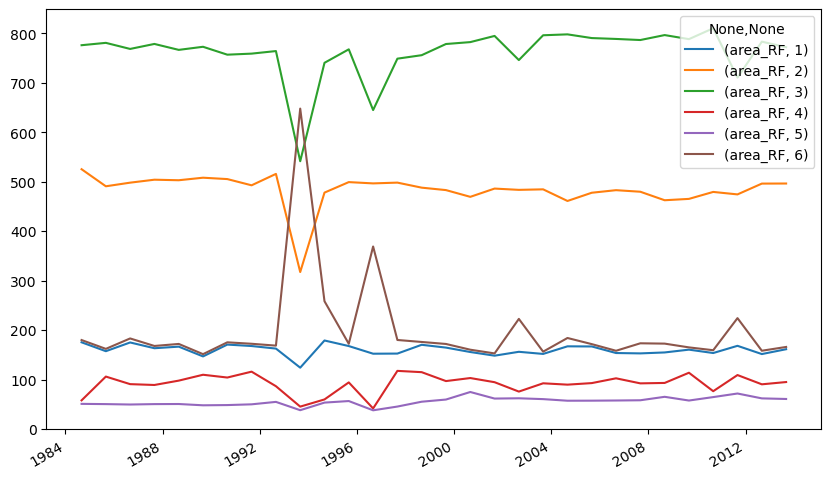

In [33]:
classArea_df.iloc[:, 8:14].plot(figsize=(10, 6.18));
#classArea_df

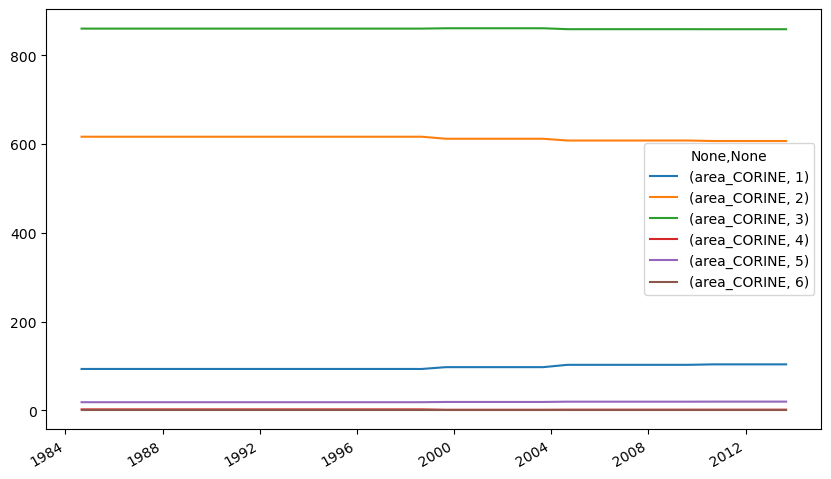

In [34]:
classArea_df.iloc[:, 2:8].plot(figsize=(10, 6.18));

In [ ]:
# Create an empty dataframe with the appropriate columns
new_df = pd.DataFrame(columns=['Column1', 'Column2', 'Column3'])

# Loop through the data and append rows to the new dataframe
for i in range(10):
    data = [i, i*2, i*3]  # Replace with your own data
    new_df.loc[len(new_df)] = data

# Load the existing dataframe with matching columns
##combined_df = pd.concat([existing_df, new_df], axis=0, ignore_index=True)

# Save the combined dataframe to a new file
new_df

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

1589.5336892619698

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map